# Zero-Shot Poor Performance Samples - Proxy

The goal of this notebook is to analyze the behavior of the generations through rag and datamodels and cases espiaclly difficults for the zero-shot.  
The current analysis is using as a proxy the 50 samples example used as "preview" in previous experimentsm which is saved in the "50_test.feather".
The resulsts used to make this analyses are the best one found in the "context_window_analysis", which corresponds to context-size 16.

The notebook will be outlined by the following questions
- What are the zero-shot poor performance questions?
- How the RAG and Datamodels choosen context impact in the performance of theses questions?
- How was the gold retrieval for these cases RAG x Datamodels?

In [108]:
import polars as pl 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

In [109]:


WIKI_PATH = "../../data/wiki_dump2018_nq_open/processed/wiki.feather"
wiki = pl.read_ipc(WIKI_PATH).with_row_index("idx")
preview = pl.read_ipc("50_test.feather").with_row_index("idx")
retrieval_indexes = {}
retrieval_indexes["rag"] = json.load(open("proxy_results/llama3.2-3b/rag_indexes.json"))
retrieval_indexes["datamodels"] = json.load(open("proxy_results/llama3.2-3b/datamodels_indexes.json"))
metrics = []
metrics.append(pl.read_ipc("proxy_results/llama3.2-3b/rag_metrics.feather").with_columns(pl.lit("rag").alias("type")))
metrics.append(pl.read_ipc("proxy_results/llama3.2-3b/datamodels_metrics.feather").with_columns(pl.lit("datamodels").alias("type")))
metrics.append(pl.read_ipc("proxy_results/llama3.2-3b/baseline_metrics.feather").with_columns(pl.lit("baseline").alias("type")))
metrics = pl.concat(metrics)

## What are the zero-shot poor performance questions?

<Axes: ylabel='Count'>

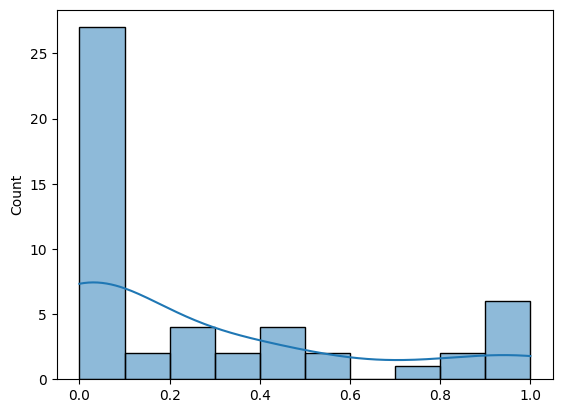

In [110]:
baseline_results = metrics.filter(pl.col("type") == "baseline").filter(pl.col("metric") == "rouge_l").select("idx", "mean").sort("mean", descending=True)
sns.histplot(baseline_results["mean"].sort(), bins=10, kde=True)

In [111]:
bad_samples_filters = baseline_results.filter(pl.col("mean") < 0.2).select("idx")
metrics_bad_samples = metrics.join(bad_samples_filters, on="idx", how="inner")
preview_bad_samples = metrics_bad_samples.join(preview, on="idx", how="inner")
len(bad_samples_filters)

29

In [112]:
preview_bad_samples.select("question").unique().head().to_series().to_list()

['who plays peter in what we do in the shadows',
 'when were cigarette ads banned from tv uk',
 'what is the main use of the eiffel tower in modern times',
 'who sings i will go down with this ship',
 'who has said that caste is a closed class']

## How the RAG and Datamodels choosen context impact in the performance of theses questions?

In [113]:
preview_bad_samples.head()

idx,mean,max,metric,type,example_id,question,answers,text,idx_gold_in_corpus
i64,f64,f64,str,str,i64,str,list[str],str,i64
0,0.0,0.0,"""rouge_l""","""rag""",-5266947057771511513,"""who was the first woman to win…","[""Judith Cynthia Aline Keppel""]","""Judith Cynthia Aline Keppel (b…",21033303
2,1.0,1.0,"""rouge_l""","""rag""",7104554727863075462,"""who's the original singer of h…","[""Kris Kristofferson""]","""'' Help Me Make It Through The…",20972472
5,0.0,0.0,"""rouge_l""","""rag""",9072437082895561605,"""who has said that caste is a c…","[""Frederik Barth""]","""Both ethnic affiliation (e.g. …",21034008
6,0.0,0.0,"""rouge_l""","""rag""",7084829719647229622,"""which term describes the repla…","[""Stromal cells""]","""When a cell cannot be regenera…",21033481
7,0.0,0.0,"""rouge_l""","""rag""",-3403542892395107762,"""how many votes to approve supr…","[""A simple majority"", ""A simple majority vote""]","""Once the Committee reports out…",21033843


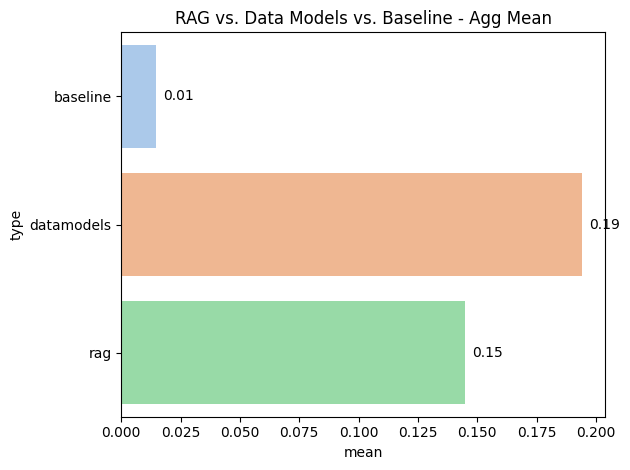

In [114]:
ax = sns.barplot(
    data=preview_bad_samples.filter(pl.col("metric") == "rouge_l").select("mean", "idx", "type").group_by(["type"]).agg(pl.col("mean").mean().alias("mean")).sort("type"),
    x="mean",
    y="type",
    hue="type",
    orient="h",
    palette="pastel",
)
plt.title("RAG vs. Data Models vs. Baseline - Agg Mean")
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f',          # Format to 2 decimal places
        padding=5,            # Space between bar and label
        fontsize=10           # Adjust font size as needed
    )

plt.tight_layout()
plt.tight_layout()
plt.show()

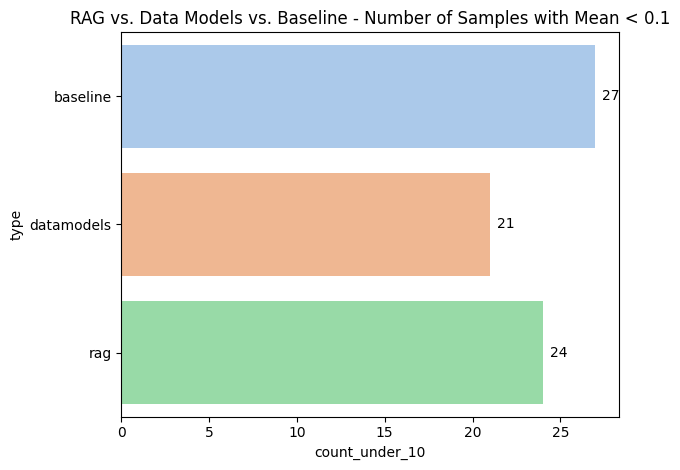

In [115]:


ax = sns.barplot(
    data=preview_bad_samples.filter(pl.col("metric") == "rouge_l").filter(pl.col("mean") < 0.1).select("mean", "idx", "type").group_by(["type"]).agg(pl.col("mean").count().alias("count_under_10")).sort("type"),
    x="count_under_10",
    y="type",
    hue="type",
    orient="h",
    palette="pastel",
)
plt.title("RAG vs. Data Models vs. Baseline - Number of Samples with Mean < 0.1")
for container in ax.containers:
    ax.bar_label(
        container,
        padding=5,            # Space between bar and label
        fontsize=10           # Adjust font size as needed
    )

plt.tight_layout()
plt.show()


<Axes: ylabel='Count'>

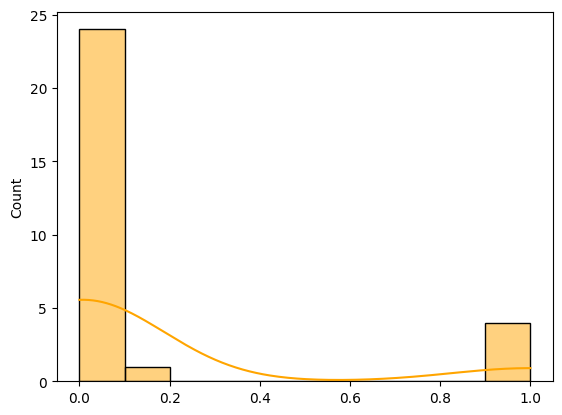

In [116]:
_temp1 = preview_bad_samples.filter(pl.col("type") == "rag").filter(pl.col("metric") == "rouge_l").select("idx", "mean").sort("mean", descending=True)
sns.histplot(_temp1["mean"].sort(), bins=10, kde=True, color="orange")

<Axes: ylabel='Count'>

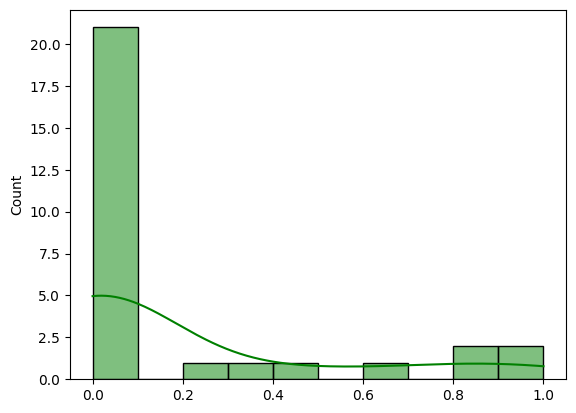

In [117]:
_temp2 = preview_bad_samples.filter(pl.col("type") == "datamodels").filter(pl.col("metric") == "rouge_l").select("idx", "mean").sort("mean", descending=True)
sns.histplot(_temp2["mean"].sort(), bins=10, kde=True, color="green")

## How was the gold retrieval for these cases RAG x Datamodels?

In [106]:
indexes = {
    "rag":  [],
    "datamodels": [],
}

for _t in ["rag", "datamodels"]:
    for _idx in range(50):
        indexes[_t].append(retrieval_indexes[_t][str(_idx)][:16])


In [123]:
list_gold = preview.select("idx_gold_in_corpus").to_series().to_list()
rag_has_gold = []
datamodels_has_gold = []
for _idx in range(50):
    is_in__rag = list_gold[_idx] in indexes["rag"][_idx]
    is_in__datamodels = list_gold[_idx] in indexes["datamodels"][_idx]
    rag_has_gold.append(is_in__rag)
    datamodels_has_gold.append(is_in__datamodels)

df_count_gold = pl.DataFrame({
    "idx": list(range(50)),
    "rag_has_gold": rag_has_gold,
    "datamodels_has_gold": datamodels_has_gold
})

In [125]:
_temp_preview = preview.join(df_count_gold, on="idx", how="inner")
print(len(_temp_preview.filter(pl.col("rag_has_gold"))))
print(len(_temp_preview.filter(pl.col("datamodels_has_gold"))))

18
24


In [128]:
_temp_preview = preview.join(df_count_gold, on="idx", how="inner").join(bad_samples_filters, on="idx", how="inner")
print(len(_temp_preview.filter(pl.col("rag_has_gold"))))
print(len(_temp_preview.filter(pl.col("datamodels_has_gold"))))

13
16


In [136]:
preview_bad_samples.join(df_count_gold, on="idx", how="inner").filter(pl.col("metric") == "rouge_l").filter(pl.col("type") == "datamodels").filter(pl.col("rag_has_gold") & pl.col("datamodels_has_gold"))

idx,mean,max,metric,type,example_id,question,answers,text,idx_gold_in_corpus,rag_has_gold,datamodels_has_gold
i64,f64,f64,str,str,i64,str,list[str],str,i64,bool,bool
16,0.0,0.0,"""rouge_l""","""datamodels""",9149664009407733120,"""who plays the robot maid in ri…","[""Brooke Wexler""]","""Jake Brennan as Richie Rich , …",21033766,true,true
21,0.0,0.0,"""rouge_l""","""datamodels""",-1330515253963834494,"""when is dancing on ice on the …","[""2019""]","""It was confirmed on 25 January…",21033021,true,true
28,0.0,0.0,"""rouge_l""","""datamodels""",3812228515775986713,"""where do the maple leafs play …","[""the Air Canada Centre"", ""Air Canada Centre""]","""The Toronto Maple Leafs ( offi…",21034727,true,true
32,0.0,0.0,"""rouge_l""","""datamodels""",2077711785168359308,"""who sang picking up pebbles an…","[""Matt Flinders""]","""Flinders ' first recording for…",21033806,true,true
35,0.0,0.0,"""rouge_l""","""datamodels""",-7986594362341759775,"""who won the first medal in oly…","[""Norman Pritchard""]","""India first participated at th…",20972568,true,true
38,0.48,1.0,"""rouge_l""","""datamodels""",4750785936593695900,"""when did the movie peter pan c…","[""2003"", ""25 December 2003""]","""Peter Pan is a 2003 fantasy ad…",21033165,true,true
41,0.0,0.0,"""rouge_l""","""datamodels""",-7316819275290398261,"""when were cigarette ads banned…","[""1 August 1965""]","""The first calls to restrict ad…",21034105,true,true
42,0.069697,0.181818,"""rouge_l""","""datamodels""",-1985459647494342298,"""how many pitchers does a major…","[""five starting pitchers"", ""seven relief pitchers""]","""Typically , in modern - day pl…",21033919,true,true
44,1.0,1.0,"""rouge_l""","""datamodels""",-9204719170990332384,"""who plays ser davos in game of…","[""Liam Cunningham""]","""Liam Cunningham ( born 2 June …",21006884,true,true
